# Ejercicio de Mediapipe library para la estimación de la pose del cuerpo humano

In [ ]:
# Install mediapipe
!pip install mediapipe 
!python3 -m pip install --force-reinstall https://github.com/yt-dlp/yt-dlp/archive/master.tar.gz

## Exercise
Write a program to process a video sequence and display the body pose per frame.

Update the previous program to overlay an image patch between the polygon defined by the torso keypoints.

Tip: you may need to use some of the ideas learnt in the previous sessions.

In [29]:
# Imports necesarios para la realización del ejercicio
import mediapipe as mp
import cv2
import yt_dlp as youtube_dl
from google.colab.patches import cv2_imshow
import numpy as np

In [30]:
#Inserción de video de youtube a google colab
ydl_opts = {'outtmpl': 'videoimage.webm',
            'format': 'bestvideo'}
with youtube_dl.YoutubeDL(ydl_opts) as ydl:
  #Swap in your YouTube videos here
  url = "https://www.youtube.com/watch?v=uUxChessSEY"
  #url = "https://www.youtube.com/watch?v=oVH3j31pV7Y"
  ydl.download([url]) 


[youtube] Extracting URL: https://www.youtube.com/watch?v=uUxChessSEY
[youtube] uUxChessSEY: Downloading webpage
[youtube] uUxChessSEY: Downloading android player API JSON
[info] uUxChessSEY: Downloading 1 format(s): 247
[download] videoimage.webm has already been downloaded
[download] 100% of    4.21MiB


In [31]:
# Variables útiles
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_pose = mp.solutions.pose


In [32]:
##version en video

In [41]:
#Descargo imagen de ejemplo para poner en el torso
!wget https://www.atptour.com/-/media/images/news/2022/03/21/01/48/nadal-indian-wells-2022-final-forehand.jpg -O imagentorso.jpg

imagentorsoname = "imagentorso.jpg"
imagetorso = cv2.imread(imagentorsoname)
h, w, _ = imagetorso.shape

#calculo esquinas de la imagen
pointsoriginales = np.float32([[0, 0], [0,h], [w,h],[w,0]])

--2023-03-27 11:58:07--  https://www.atptour.com/-/media/images/news/2022/03/21/01/48/nadal-indian-wells-2022-final-forehand.jpg
Resolving www.atptour.com (www.atptour.com)... 104.18.14.11, 104.18.15.11, 2606:4700::6812:e0b, ...
Connecting to www.atptour.com (www.atptour.com)|104.18.14.11|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 99460 (97K) [image/jpeg]
Saving to: ‘imagentorso.jpg’

imagentorso.jpg     100%[===================>]  97.13K  --.-KB/s    in 0.02s   

2023-03-27 11:58:07 (3.82 MB/s) - ‘imagentorso.jpg’ saved [99460/99460]



In [48]:
#capturamos video y comprobamos si ha sido de forma correcta
cap = cv2.VideoCapture("videoimage.webm")
if not cap.isOpened():
  print("Cannot open video")
  exit()

#cogemos fps y ancho y alto de la entrada
width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = int(cap.get(cv2.CAP_PROP_FPS))

#escogemos el código en el que se guardará el video
fourcc = cv2.VideoWriter_fourcc(*'MP4V') #codec
out = cv2.VideoWriter('video.mp4', fourcc, fps, (width, height))

#creamos el objeto pose para su posterior uso
pose = mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5)

#mientras el video tenga frames se realiza el procesamiento
while True:

  # se captura frame a frame
  ret, image = cap.read()
  # si el frame no se escoge correctamente o no hay se para el procesamiento
  if ret == False:
    print("Fin Video")
    break

  #cojo columnas y filas para trabajar sobre la imagen
  rows, cols, _ = image.shape

  #se realiza el procesamiento
  image.flags.writeable = False
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  results = pose.process(image)

  image.flags.writeable = True
  image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

  try:
    #se escogen las coordenadas para los 4 puntos
    x_coodinate_RIGHT_SHOULDER = results.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_SHOULDER].x * width
    y_coodinate_RIGHT_SHOULDER = results.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_SHOULDER].y * height

    x_coodinate_LEFT_SHOULDER = results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_SHOULDER].x * width
    y_coodinate_LEFT_SHOULDER = results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_SHOULDER].y * height

    x_coodinate_LEFT_HIP = results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_HIP].x * width
    y_coodinate_LEFT_HIP = results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_HIP].y * height

    x_coodinate_RIGHT_HIP = results.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_HIP].x * width
    y_coodinate_RIGHT_HIP = results.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_HIP].y * height



    points = np.float32([[x_coodinate_RIGHT_SHOULDER, y_coodinate_RIGHT_SHOULDER], 
                        [x_coodinate_LEFT_SHOULDER, y_coodinate_LEFT_SHOULDER], 
                        [x_coodinate_LEFT_HIP,y_coodinate_LEFT_HIP],
                        [x_coodinate_RIGHT_HIP,y_coodinate_RIGHT_HIP]])
      #print(points)
      
    #tranformamos la imagen que se desea poner al poligono obtenido
    transform_mat = cv2.getPerspectiveTransform(pointsoriginales, points)

    #ajustamos la perspectiva
    aux = cv2.warpPerspective(imagetorso, transform_mat, (cols,rows))#cambio patch a perspectiva de la escena con el tamaño de la misma
      
    #colocamos la imagen en los puntos especificados
    cv2.fillPoly(image,np.int32([points]),color=(0, 0, 0))
    image=image|aux;
  except:
   print("No se encontraron las 4 esquinas del polígono")

  #se dibujan los resultados (los keypoints encontrados)
  mp_drawing.draw_landmarks(
    image,
    results.pose_landmarks,
    mp_pose.POSE_CONNECTIONS,
    landmark_drawing_spec=mp_drawing_styles.get_default_pose_landmarks_style())
  

# Guardamos la imagen procesada
  out.write(image)
  #cv2_imshow(image)
  if cv2.waitKey(1) == ord('q'):#a la q se pararía el procesamiento del video
      break
# Cuando todo termine, se libera la captura
cap.release()
out.release()

No se encontraron las 4 esquinas del polígono
No se encontraron las 4 esquinas del polígono
No se encontraron las 4 esquinas del polígono
No se encontraron las 4 esquinas del polígono
No se encontraron las 4 esquinas del polígono
No se encontraron las 4 esquinas del polígono
No se encontraron las 4 esquinas del polígono
No se encontraron las 4 esquinas del polígono
No se encontraron las 4 esquinas del polígono
No se encontraron las 4 esquinas del polígono
No se encontraron las 4 esquinas del polígono
Fin Video


# Ejemplo de uso para imagen:

In [35]:
# Imports necesarios para la realización del ejercicio
import mediapipe as mp
import cv2
import yt_dlp as youtube_dl
from google.colab.patches import cv2_imshow
import numpy as np

In [36]:
# Variables útiles
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_pose = mp.solutions.pose


In [37]:
# Download image

# Examples with single person
#!wget https://us.123rf.com/450wm/vgstudio/vgstudio1204/vgstudio120400139/13243757-corpo-pieno-di-felice-uomo-sorridente-giovane-affari-dando-mano-per-stretta-di-mano-isolato-su-sfond.jpg -O testimage.jpg
#!wget https://www.atptour.com/-/media/images/news/2022/03/21/01/48/nadal-indian-wells-2022-final-forehand.jpg -O testimage.jpg
#!wget https://e00-elmundo.uecdn.es/assets/multimedia/imagenes/2022/03/28/16484387631723.jpg -O testimage.jpg
!wget https://imagenes.20minutos.es/files/image_656_370/uploads/imagenes/2022/03/29/will-smith-con-su-oscar-por-el-metodo-williams.jpeg -O testimage.jpg

# Example with more than one person
#!wget https://static1.abc.es/media/deportes/2022/03/18/nadal-alcaraz-kL3D--620x349@abc.jpg -O testimage.jpg
#!wget https://static.dw.com/image/61276701_303.jpg -O testimage.jpg

--2023-03-27 11:41:36--  https://imagenes.20minutos.es/files/image_656_370/uploads/imagenes/2022/03/29/will-smith-con-su-oscar-por-el-metodo-williams.jpeg
Resolving imagenes.20minutos.es (imagenes.20minutos.es)... 108.157.162.56, 108.157.162.128, 108.157.162.52, ...
Connecting to imagenes.20minutos.es (imagenes.20minutos.es)|108.157.162.56|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 22403 (22K) [image/jpeg]
Saving to: ‘testimage.jpg’

testimage.jpg       100%[===================>]  21.88K  --.-KB/s    in 0.002s  

2023-03-27 11:41:36 (9.34 MB/s) - ‘testimage.jpg’ saved [22403/22403]



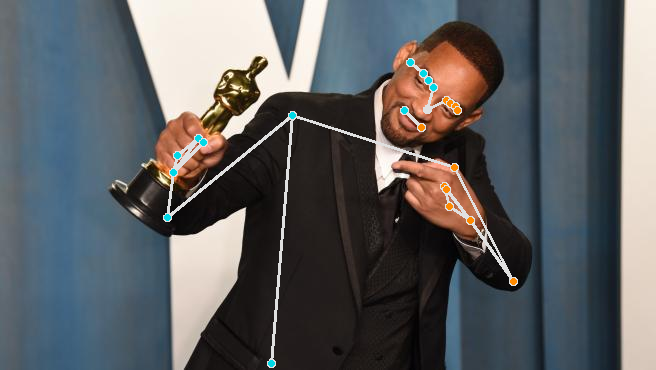

In [38]:
imagename = "testimage.jpg"
image = cv2.imread(imagename)

pose = mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5)

image.flags.writeable = False
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
results = pose.process(image)

image.flags.writeable = True
image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

mp_drawing.draw_landmarks(
    image,
    results.pose_landmarks,
    mp_pose.POSE_CONNECTIONS,
    landmark_drawing_spec=mp_drawing_styles.get_default_pose_landmarks_style())
    
cv2_imshow(image)

## The 3D pose can be estimated as well. Let's see how.


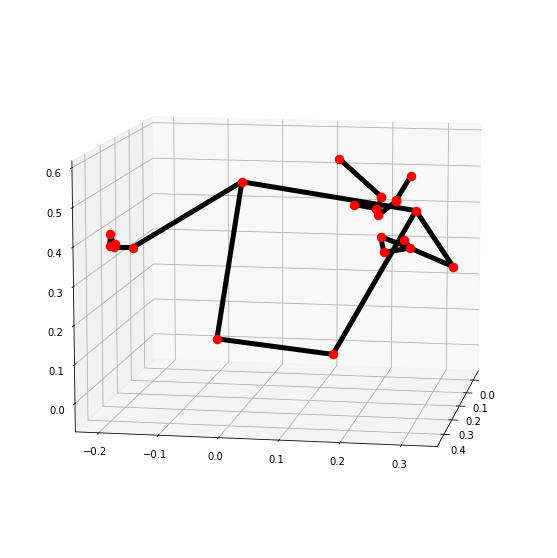

In [39]:
# Pay attention to the attribute used from the 'results' object.
mp_drawing.plot_landmarks(
        results.pose_world_landmarks, mp_pose.POSE_CONNECTIONS) 
 